In [150]:
!pip install surprise

In [1]:
# Import Packages
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

import xgboost as xgb
from surprise import Reader, Dataset, BaselineOnly, KNNBaseline, SVD, SVDpp
from surprise.model_selection import KFold, GridSearchCV, cross_validate

In [2]:
dfR = pd.read_csv('./ratings.csv')
dfR.sample(4)

,userId,movieId,rating,timestamp
59498,422,1210,4.5,1075070263
99290,665,54999,3.0,1231678904
97555,648,736,4.0,859029646
63015,446,230,3.0,835116605


In [3]:
dfM= pd.read_csv('./movies.csv')
dfM.sample(4)

,movieId,title,genres
8570,78034,Cemetery Junction (2010),Comedy|Drama|Romance
10015,113240,Winter Sleep (Kis Uykusu) (2014),Drama
2926,3704,Mad Max Beyond Thunderdome (1985),Action|Adventure|Sci-Fi
5347,7386,"Ten Commandments, The (1956)",Adventure|Drama


In [4]:
#dfR['userid'] = dfR['userid'].fillna('NULL')
dfPivot = dfR.pivot_table(columns=["userId", "movieId", "rating", "timestamp"], aggfunc='size')
dfPivot

userId  movieId  rating  timestamp 
1       16       4.0     1217897793    1
        24       1.5     1217895807    1
        32       4.0     1217896246    1
        47       4.0     1217896556    1
        50       4.0     1217896523    1
                                      ..
668     142488   4.0     1451535844    1
        142507   3.5     1451535889    1
        143385   4.0     1446388585    1
        144976   2.5     1448656898    1
        148626   4.5     1451148148    1
Length: 105339, dtype: int64

In [5]:
dfDup = dfR.groupby(['rating','movieId'], as_index=True).size()
dfDup

rating  movieId
0.5     2          1
        16         1
        19         3
        32         1
        34         1
                  ..
5.0     139385     1
        139620     1
        139644     2
        140820     1
        143385     1
Length: 31784, dtype: int64

In [6]:
# Get count duplicates for each unique row
dfDup = dfR.groupby(dfR.columns.tolist(), as_index=True).size()
dfDup

userId  movieId  rating  timestamp 
1       16       4.0     1217897793    1
        24       1.5     1217895807    1
        32       4.0     1217896246    1
        47       4.0     1217896556    1
        50       4.0     1217896523    1
                                      ..
668     142488   4.0     1451535844    1
        142507   3.5     1451535889    1
        143385   4.0     1446388585    1
        144976   2.5     1448656898    1
        148626   4.5     1451148148    1
Length: 105339, dtype: int64

In [7]:
movie_data = pd.merge(dfR, dfM, on='movieId')
movie_data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,1217897793,Casino (1995),Crime|Drama
1,9,16,4.0,842686699,Casino (1995),Crime|Drama
2,12,16,1.5,1144396284,Casino (1995),Crime|Drama
3,24,16,4.0,963468757,Casino (1995),Crime|Drama
4,29,16,3.0,836820223,Casino (1995),Crime|Drama


In [8]:
# Number of users
print('The ratings dataset has', movie_data['userId'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', movie_data['movieId'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', movie_data['rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(movie_data['rating'].unique()))

The ratings dataset has 668 unique users
The ratings dataset has 10325 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [9]:
movie_data.groupby('title')['rating'].mean().head()

title
'71 (2014)                                 3.500
'Hellboy': The Seeds of Creation (2004)    3.000
'Round Midnight (1986)                     2.500
'Til There Was You (1997)                  4.000
'burbs, The (1989)                         3.125
Name: rating, dtype: float64

In [10]:
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Saddest Music in the World, The (2003)    5.0
Interstate 60 (2002)                      5.0
Gunfighter, The (1950)                    5.0
Heima (2007)                              5.0
Limelight (1952)                          5.0
Name: rating, dtype: float64

In [11]:
movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Pulp Fiction (1994)                 325
Forrest Gump (1994)                 311
Shawshank Redemption, The (1994)    308
Jurassic Park (1993)                294
Silence of the Lambs, The (1991)    290
Name: rating, dtype: int64

In [12]:
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())

In [13]:
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())

In [14]:
ratings_mean_count.head()

,rating,rating_counts
title,,
'71 (2014),3.500,1
'Hellboy': The Seeds of Creation (2004),3.000,1
'Round Midnight (1986),2.500,1
'Til There Was You (1997),4.000,3
"'burbs, The (1989)",3.125,20


<Axes: >

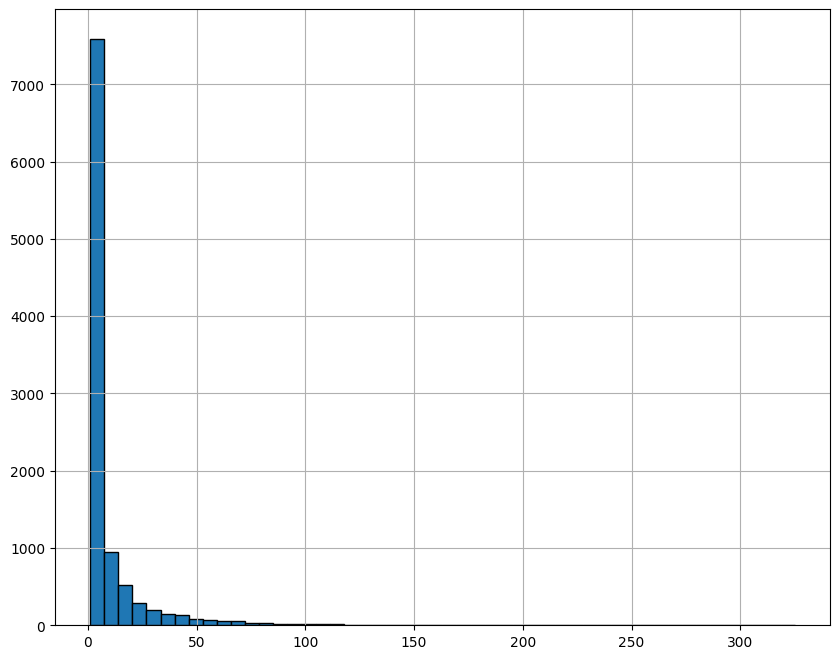

In [33]:
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD', '#4E79A7', '#E69F00', '#F0E442', '#59A14F', '#8C8C8C', '#9C755F', '#EDB8A7', '#BDBDBD', '#000000']
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Axes: >

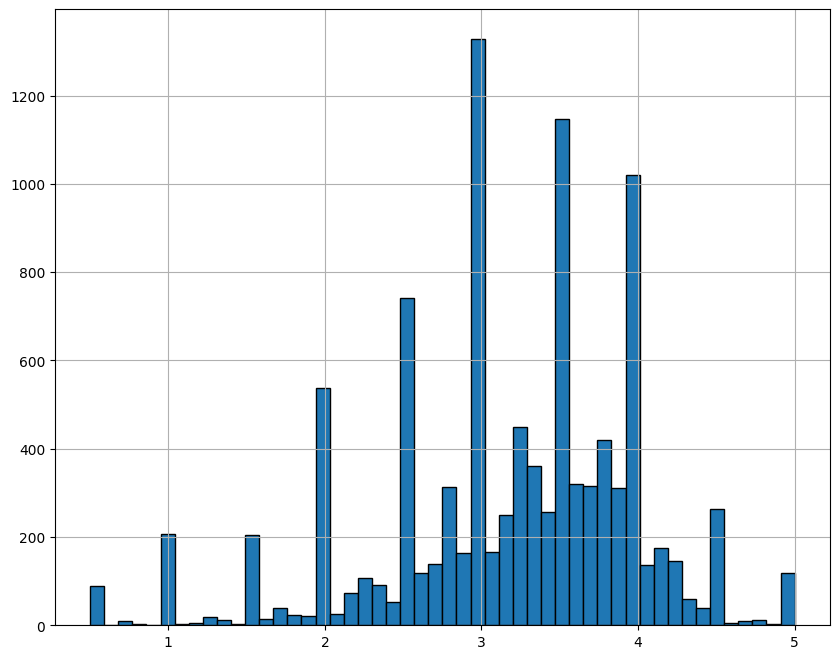

In [35]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 1000x800 with 0 Axes>

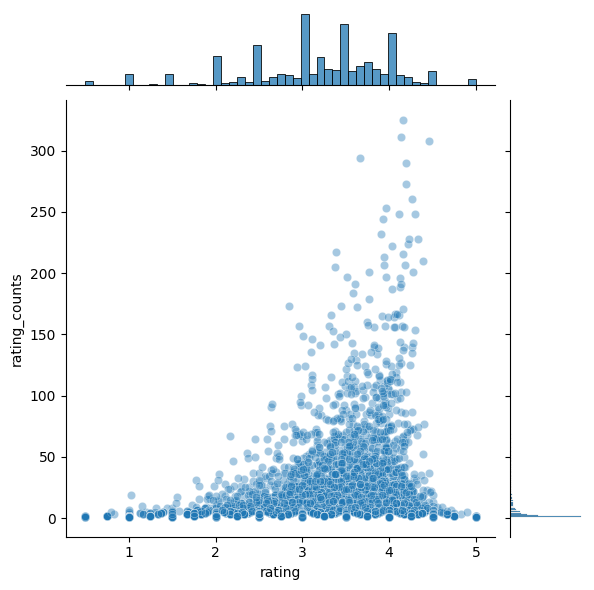

In [36]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [15]:
user_movie_rating = movie_data.pivot_table(index='userId', columns='title', values='rating')

user_movie_rating.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 (1979),...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),a/k/a Tommy Chong (2005),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
forrest_gump_ratings = user_movie_rating['Forrest Gump (1994)']

forrest_gump_ratings.head()

userId
1    3.0
2    NaN
3    3.0
4    NaN
5    NaN
Name: Forrest Gump (1994), dtype: float64

In [17]:
movies_like_forest_gump = user_movie_rating.corrwith(forrest_gump_ratings)

c:\Users\saifu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\saifu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [18]:
corr_forrest_gump = pd.DataFrame(movies_like_forest_gump, columns=['Correlation'])
corr_forrest_gump.dropna(inplace=True)
corr_forrest_gump.head()

,Correlation
title,
"'burbs, The (1989)",0.056266
(500) Days of Summer (2009),0.144325
*batteries not included (1987),0.000000
...And Justice for All (1979),0.089924
10 (1979),0.693375


In [19]:
corr_forrest_gump.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
Martian Child (2007),1.0
First Kid (1996),1.0
Shortbus (2006),1.0
"Court Jester, The (1956)",1.0
Bottle Shock (2008),1.0
Anna Karenina (2012),1.0
Elegy (2008),1.0
Half Light (2006),1.0
"Unvanquished, The (Aparajito) (1957)",1.0


In [20]:
corr_forrest_gump = corr_forrest_gump.join(ratings_mean_count['rating_counts'])
corr_forrest_gump.head()

,Correlation,rating_counts
title,,
"'burbs, The (1989)",0.056266,20
(500) Days of Summer (2009),0.144325,37
*batteries not included (1987),0.000000,11
...And Justice for All (1979),0.089924,10
10 (1979),0.693375,3


In [21]:
corr_forrest_gump[corr_forrest_gump ['rating_counts']>50].sort_values('Correlation', ascending=False).head()

,Correlation,rating_counts
title,,
Forrest Gump (1994),1.000000,311
Happy Gilmore (1996),0.715602,79
12 Angry Men (1957),0.545139,63
As Good as It Gets (1997),0.521448,98
First Knight (1995),0.520438,52


In [22]:
# Aggregate by movie
agg_ratings = movie_data.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()
# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
# Check the information of the dataframe
agg_ratings_GT100.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 60 to 10204
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              150 non-null    object 
 1   mean_rating        150 non-null    float64
 2   number_of_ratings  150 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.7+ KB


In [23]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
7323,Pulp Fiction (1994),4.160000,325
3349,Forrest Gump (1994),4.138264,311
8136,"Shawshank Redemption, The (1994)",4.454545,308
4934,Jurassic Park (1993),3.659864,294
8228,"Silence of the Lambs, The (1991)",4.194828,290


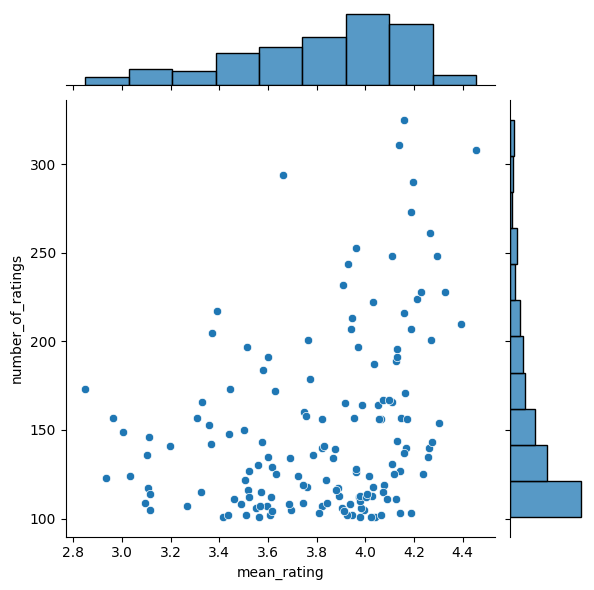

In [24]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [25]:
# Merge data
df_GT100 = pd.merge(movie_data, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22556 entries, 0 to 22555
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     22556 non-null  int64  
 1   movieId    22556 non-null  int64  
 2   rating     22556 non-null  float64
 3   timestamp  22556 non-null  int64  
 4   title      22556 non-null  object 
 5   genres     22556 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.2+ MB


In [26]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='title', columns='userId', values='rating')
matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.5,NaN
Aladdin (1992),NaN,NaN,3.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
Alien (1979),NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,2.0,NaN,4.0,NaN,4.0
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5


In [52]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
matrix_norm.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.039683,NaN,NaN,NaN,NaN,NaN,-0.960317
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,-1.849711,NaN,-1.849711,NaN,-0.849711,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.150289,NaN,0.650289,NaN
Aladdin (1992),NaN,NaN,-0.602094,NaN,-0.102094,NaN,NaN,NaN,NaN,NaN,...,-0.602094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.602094
Alien (1979),NaN,NaN,NaN,NaN,NaN,NaN,0.935897,NaN,NaN,NaN,...,NaN,NaN,NaN,0.935897,NaN,-2.064103,NaN,-0.064103,NaN,-0.064103
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,0.853503,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.646497


In [27]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(dfR.values)
distances, indices = knn.kneighbors(dfR.values, n_neighbors=3)

In [30]:
indices

array([[   117,    115,    116],
       [     1,    116,    117],
       [   117,    809,      4],
       ...,
       [105336,  94595,  70598],
       [105337,  70600,  66813],
       [105338,  86152,  66814]], dtype=int64)

In [32]:
reader = Reader()
ratings = pd.read_csv('./ratings_small.csv')  # Unable to allocate 15.4 GiB for an array with shape (45463, 45463) and data type float64
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [33]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)

<generator object KFold.split at 0x0000019E1F80DF80>

In [118]:
# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8914  0.8951  0.8973  0.9073  0.8953  0.8973  0.0054  
MAE (testset)     0.6894  0.6877  0.6905  0.6984  0.6880  0.6908  0.0039  
Fit time          2.20    2.14    1.99    1.91    1.74    2.00    0.16    
Test time         0.30    0.23    0.31    0.22    0.26    0.27    0.03    


{'test_rmse': array([0.89142658, 0.89508881, 0.89734784, 0.90729022, 0.89529814]),
 'test_mae': array([0.68943876, 0.68768863, 0.69047015, 0.69838152, 0.68795425]),
 'fit_time': (2.2021710872650146,
  2.1402411460876465,
  1.9913668632507324,
  1.9108026027679443,
  1.740940809249878),
 'test_time': (0.298356294631958,
  0.2349536418914795,
  0.3103022575378418,
  0.2222728729248047,
  0.2601335048675537)}

#### Root Mean Sqaure Error of 0.8963 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [119]:
trainset = data.build_full_trainset()
#algo.train(trainset)
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [120]:
algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.8906995392996517, details={'was_impossible': False})

### Simple Recommender

The Simple Recommender offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list. As an added step, we can pass in a genre argument to get the top movies of a particular genre.

In [53]:
md = pd. read_csv('./movies_metadata.csv')
md.head()

C:\Users\saifu\AppData\Local\Temp\ipykernel_23544\3515996879.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd. read_csv('./movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [56]:
md['genres'].head(5).tolist()

["[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",
 "[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",
 "[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",
 "[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",
 "[{'id': 35, 'name': 'Comedy'}]"]

In [57]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


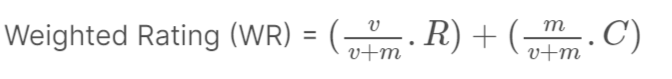
 
where,
<ul>
    <li>v is the number of votes for the movie</li>
    <li>m is the minimum votes required to be listed in the chart</li>
    <li>R is the average rating of the movie</li>
    <li>C is the mean vote across the whole report</li>
</ul>
The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [58]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [59]:
m = vote_counts.quantile(0.95)
m

434.0

In [60]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [61]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [63]:
qualified['genres'].head(50).tolist()

[['Animation', 'Comedy', 'Family'],
 ['Adventure', 'Fantasy', 'Family'],
 ['Action', 'Crime', 'Drama', 'Thriller'],
 ['Adventure', 'Action', 'Thriller'],
 ['Drama', 'Crime'],
 ['Crime', 'Comedy'],
 ['Crime', 'Comedy', 'Adventure'],
 ['Science Fiction', 'Thriller', 'Mystery'],
 ['Fantasy', 'Drama', 'Comedy', 'Family'],
 ['Comedy', 'Drama', 'Romance'],
 ['Action', 'Fantasy'],
 ['Crime', 'Mystery', 'Thriller'],
 ['Adventure', 'Animation', 'Drama', 'Family'],
 ['Drama', 'Crime', 'Thriller'],
 ['Comedy'],
 ['Horror', 'Action', 'Thriller', 'Crime'],
 ['Action', 'Adventure', 'Drama', 'Thriller'],
 ['Drama'],
 ['Comedy'],
 ['Action', 'Drama', 'History', 'War'],
 ['Crime', 'Drama'],
 ['Action', 'Comedy', 'Crime', 'Thriller'],
 ['Drama', 'Crime'],
 ['Drama'],
 ['Action', 'Crime', 'Fantasy'],
 ['Fantasy', 'Comedy', 'Family'],
 ['Action', 'Thriller', 'Drama'],
 ['Thriller', 'Action', 'Crime'],
 ['Action', 'Thriller'],
 ['Science Fiction'],
 ['Science Fiction', 'Horror', 'Action'],
 ['Adventure', '

Therefore, to qualify to be considered for the chart, a movie has to have at least 434 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10. 2274 Movies qualify to be on our chart.

In [42]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [43]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [44]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [45]:
# Top 15 movies
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [46]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

C:\Users\saifu\AppData\Local\Temp\ipykernel_23544\2744528521.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)


In [47]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [52]:
build_chart('Documentary').head(15)

,title,year,vote_count,vote_average,popularity,wr
43320,Planet Earth II,2016,50,9,5.651997,8.063355
16881,Senna,2010,282,8,11.331859,7.847945
21556,One Direction: This Is Us,2013,209,8,5.988929,7.799122
39085,Planet Earth,2006,176,8,4.501137,7.765013
23325,Jodorowsky's Dune,2013,172,8,6.18442,7.760075
19392,Samsara,2011,169,8,9.491177,7.756233
3555,Baraka,1992,156,8,9.925348,7.738058
12027,The King of Kong,2007,148,8,5.376821,7.725460
13252,Dear Zachary: A Letter to a Son About His Father,2008,146,8,5.531686,7.722120
25802,The Salt of the Earth,2014,146,8,5.154091,7.722120


In [133]:
# Top romance movies
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


### Content Based Recommender

To personalise our recommendations more, I am going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as Content Based Filtering.

In [134]:
links = pd.read_csv('./links.csv')
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')
links

0           862
1          8844
2         15602
3         31357
4         11862
          ...  
45838    439050
45839    111109
45840     67758
45841    227506
45842    461257
Name: tmdbId, Length: 45624, dtype: int32

In [142]:
df2=md[md.index.isin([19730, 29503, 35587])]
df2

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


#### meata data id has 1997-08-20, 2012-09-29 and 2014-01-01

In [143]:
md = md.drop([19730, 29503, 35587])

In [110]:
links.info()

<class 'pandas.core.series.Series'>
Int64Index: 45624 entries, 0 to 45842
Series name: tmdbId
Non-Null Count  Dtype
--------------  -----
45624 non-null  int32
dtypes: int32(1)
memory usage: 534.7 KB


In [144]:
md['id'] = md['id'].astype('int')
smd = md[md['id'].isin(links)]
smd.shape

(45463, 25)

#### Movie Description Based Recommender


In [145]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

#### Term Frequency Inverse Document Frequency (TFIDF)

ngram_range: An n-gram is a string of words in a row. For example, in the sentence – “Text processing is easy.”, 2-grams could be ‘Text processing’, ‘processing is’ or ‘is easy’. We can set the ngram_range to be (x,y) where x is the minimum and y is the maximum size of the n-grams we want to include in the features. The default ngram_range is (1,1).

In [146]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])
tfidf_matrix.shape

(45463, 1104495)

#### Cosine Similarity
We will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

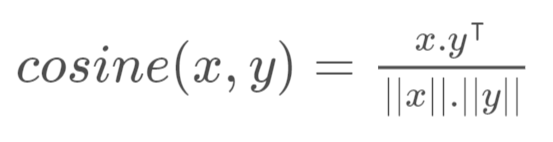

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [148]:
#method 1:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)[0,1])
# 0.005118108840121611

#method 2:
from sklearn.metrics.pairwise import pairwise_distances
print(pairwise_distances(tfidf_matrix[0:1], tfidf_matrix, metric='cosine')[0,1])
# 0.9948818911598784

0.005118108840121611
0.9948818911598784


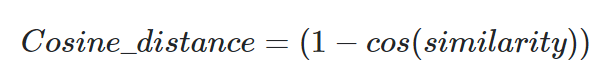


Pairwise distance measures, which many ML-based algorithms (supervised\unsupervised) use the following distance measures/metrics:
<ul>
    <li>Euclidean Distance</li>
    <li>Cosine Similarity</li>
    <li>Hamming Distance</li>
    <li>Manhattan Distance</li>
    <li>Chebyshev Distance</li>
    <li>Minkowski</li>
    <li>Jaccard Index</li>
    <li>Haversine</li>
    <li>Sørensen-Dice Index</li>
    <li>Gower’s Distance</li>
</ul>

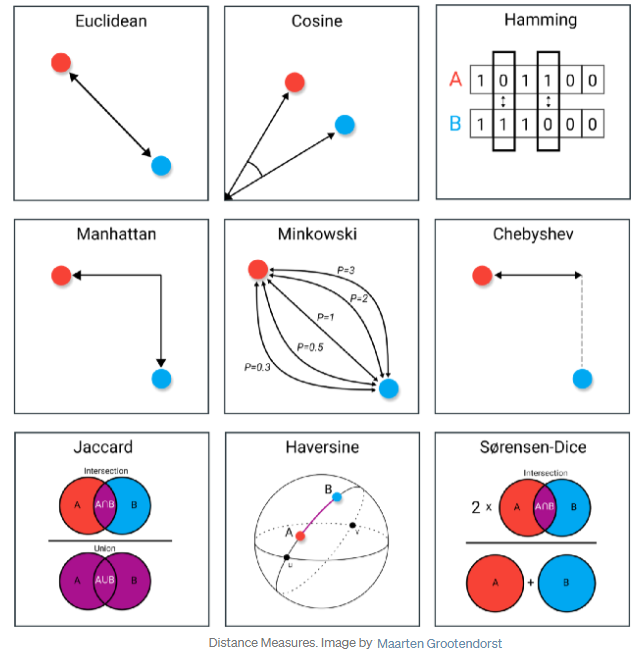

In [147]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

MemoryError: Unable to allocate 4.58 GiB for an array with shape (614620813,) and data type float64